# Convolutional Neural Networks

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/deep-learning-intro/">https://d9w.github.io/deep-learning-intro/</a><br>Based on the Supaero Data Science Deep Learning class: https://supaerodatascience.github.io/deep-learning/

The main factor which makes deep learning so useful for computer vision is the use of convolutions. Convolutional networks exploit the fact that the data is actually an image in the learning while decreasing the number of weights in the network. To do this, they define **convolution filters** that brush across the image. Such a filter defines a so-called **feature map** that shares the weights of the filter. The result of applying a feature map on an image is a new image of lower resolution, where each pixel is the result of the convolution of the filter with a set of pixels from the input image, as illustrated on the figure below. The Stanford class [CS231n](http://cs231n.github.io/convolutional-networks/) also has an excellent demo.

<img src="img/convnet.gif" width="700px">

In [63]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
%matplotlib inline
import matplotlib.pyplot as plt

In [64]:
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

full_trainset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
trainset, full_validset = torch.utils.data.random_split(full_trainset, (10000, 50000))
validset, _ = torch.utils.data.random_split(full_validset, (1000, 49000))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=4, shuffle=False, num_workers=2)

In [65]:
def forward_convolution(conv_W, conv_b, data):
    """
    Compute the output from a convolutional layer given the weights and data.

    conv_W is of the shape (# output channels, # input channels, convolution width, convolution height )
    conv_b is of the shape (# output channels)

    data is of the shape (# input channels, width, height)

    The output should be the result of a convolution and should be of the size:
        (# output channels, width - convolution width + 1, height -  convolution height + 1)

    Returns:
        The output of the convolution as a numpy array
    """

    conv_channels, _, conv_width, conv_height = conv_W.shape

    input_channels, input_width, input_height = data.shape

    output = np.zeros((conv_channels, input_width - conv_width + 1, input_height - conv_height + 1))

    for x in range(input_width - conv_width + 1):
        for y in range(input_height - conv_height + 1):
            for output_channel in range(conv_channels):
                output[output_channel, x, y] = np.sum(
                    np.multiply(data[:, x:(x + conv_width), y:(y + conv_height)], conv_W[output_channel, :, :, :])) + conv_b[output_channel]

    return output

In [66]:
rng = np.random.default_rng()
data = rng.integers(-5, 5, (1, 3, 3))
conv_W = np.array([[np.identity(2)]]) #np.ones((1, 1, 2, 2))
conv_b = np.zeros(1)
output = forward_convolution(conv_W, conv_b, data)
print("Input:\n", data)
print("Filter:\n", conv_W)
print("Bias:", conv_b)
print("Output:\n", output)

Input:
 [[[-5 -4 -1]
  [-3  4 -5]
  [ 1 -3  0]]]
Filter:
 [[[[1. 0.]
   [0. 1.]]]]
Bias: [0.]
Output:
 [[[-1. -9.]
  [-6.  4.]]]


Convolutional layers extract important features from previous layers, transforming the image space into a feature space where each block of neurons corresponds to a feature set rather than a group of pixels. To aggregate these features, select the most important ones, and reduce the dimensionality of our network, we'll use the **pooling** operator. Pooling is the operation of down-sampling the image by grouping together certain pixels. The most common pooling operation takes the maximum value over a certain window. Max pooling has been shown to better separate features which are rare in the data.

Boureau, Y-Lan, Jean Ponce, and Yann LeCun. "A theoretical analysis of feature pooling in visual recognition." Proceedings of the 27th international conference on machine learning (ICML-10). 2010. [pdf](https://www.di.ens.fr/willow/pdfs/icml2010b.pdf)

<img src="img/maxpool.png">

One of the advantages of convolution is translational invariance: a feature can appear in different parts of an image, and the network will still detect it. Here's a simple example:

<img src="img/invariance.png">

When defining a convolutional layer, we define the number of channels, where a channel is one slice of neurons. Our input image has one channel - the dimensions are 28 by 28 by 1. A color image has three channels, red green and blue. Using convolution, we'll convert our image of 28 by 28 by 1 into a number of different channels, which we call feature maps. The other parameter we define is the size of the kernel - how large is the filter we're passing over the previous layer. 

`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')`

The options of stride, padding, dilation, and groups are further explained in the [documentation](https://pytorch.org/docs/stable/nn.html?highlight=torch%20nn%20conv2d#torch.nn.Conv2d). [This page](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) shows an illustration of these different options.

In [67]:
m = torch.nn.Conv2d(1, 1, 2, stride=1)
m.weight = torch.nn.Parameter(torch.tensor(conv_W, dtype=torch.float))
m.bias = torch.nn.Parameter(torch.tensor(conv_b, dtype=torch.float))
input = torch.tensor(np.array([data]), dtype=torch.float)
output = m(input)
print("Input:", input)
print("Weight:", m.weight)
print("Bias:", m.bias)
print("Output:", output)

Input: tensor([[[[-5., -4., -1.],
          [-3.,  4., -5.],
          [ 1., -3.,  0.]]]])
Weight: Parameter containing:
tensor([[[[1., 0.],
          [0., 1.]]]], requires_grad=True)
Bias: Parameter containing:
tensor([0.], requires_grad=True)
Output: tensor([[[[-1., -9.],
          [-6.,  4.]]]], grad_fn=<ThnnConv2DBackward>)


This creates the difficult question of how large is our convolutional layer, in terms of dimensions? Let's assume a layer with the following:

+ batch size $N$
+ input layer size $H_{in}$ by $W_{in}$
+ $C_{in}$ input channels
+ $C_{out}$ output channels
+ Kernel size $K$, assuming 2D for now

That is to say, the previous layer's size is $(N, C_{in}, H_{in}, W_{in})$. For our image input layer, this is $(512, 1, 28, 28)$. We want to calculate the size of the convolutional layer, $(N, C_{out}, H_{out}, W_{out})$. 

This size depends on our kernel size and the other convolutional parameters like stride and padding:

$$H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0] \times (K_0 - 1) - 1}{\text{stride}[0]} + 1\right\rfloor$$
 
$$W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]\times (K_1 - 1) - 1}{\text{stride}[1]} + 1\right\rfloor$$

Assuming the torch defaults of `stride=1, padding=0, dilation=1`, this simplifies to:

$$H_{out} = \left\lfloor H_{in} - K_0 + 1\right\rfloor$$
 
$$W_{out} = \left\lfloor W_{in} - K_1 + 1\right\rfloor$$

Note that this is straight from the [torch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d).

We'll use this calculation to make a small network with 8 feature maps and a kernel size of 4 by 4.

In [68]:
k = (4, 4)
h_in = 28
w_in = 28
c_in = 1
c_out = 8

In [69]:
output_size = c_out * (h_in - k[0] + 1) * (w_in - k[1] + 1)
print(output_size)

5000


In [70]:
def train(net):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss

In [71]:
def get_valid_predictions(net):
    validloader = torch.utils.data.DataLoader(validset, batch_size=4, shuffle=False)
    all_labels = np.array([])
    predictions = np.array([])
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels = np.append(all_labels, labels.numpy())
            predictions = np.append(predictions, predicted.numpy())
    return all_labels, predictions

In [72]:
# %load solutions/ex6.py
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.relu(x)
        return output

net = ConvNet()
train(net)
y_valid, predictions = get_valid_predictions(net)
print('Accuracy: ', accuracy_score(predictions, y_valid))


Accuracy:  0.21


<div class="alert alert-info">
    <h3>Discussion</h3>
    
We previously defined backpropagation for feed-forward networks which used the gradient of the weighted sum and neural activation function. Can backpropagation still work with these two layer types, convolution and pooling? How? What requirement is there for the operators performed by each layer?
</div>

# <a id="sec7">7. Improving Optimization</a>

Just to review, training a neural network is a function of maximizing some objective function $Q$; it is a process of optimization. $Q$ can be, for example, a MSE Loss function:
$$
Q_i(\theta) = (X(\theta, i) - h_i)^2\\
Q(\theta) = \frac{1}{n}\sum_{i=1}^n Q_i(\theta)
$$
So far, we've been using SGD for this optimization:

In [73]:
net = ConvNet()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

In other words, we're doing our weight ($\theta$) update according to the following:

$$
\Delta \theta^{(t+1)} \leftarrow \alpha\Delta \theta^{(t)}-\eta\nabla Q_i (\theta^{(t)})\\
\theta^{(t+1)} \leftarrow \theta^{(t)} + \Delta \theta^{(t+1)}
$$

These two hyperparameters, learning rate ($\alpha$) and momentum ($\eta$), change how the neural network minimizes the loss and can have drastic impact on the learning.

<img src="https://github.com/SupaeroDataScience/deep-learning/raw/main/deep/img/sgd.gif" width="80%">

A popular optimizer is the Adaptive Moment Estimation ([Adam](https://arxiv.org/pdf/1412.6980.pdf)) optimizer. This optimizer takes into account the recent weight changes when making a new update:

$$
m_\theta^{(t+1)} \leftarrow \beta_1 m_\theta^{(t)} + (1-\beta_1) \nabla Q_i(\theta^{(t)})\\
v_\theta^{(t+1)} \leftarrow \beta_2 v_\theta^{(t)} + (1-\beta_2)(\nabla Q_i(\theta^{(t)}))^2\\
\hat{m}_\theta = \frac{m_\theta^{(t+1)}}{1-\beta_1^t}\\
\hat{v}_\theta = \frac{v_\theta^{(t+1)}}{1-\beta_2^t}\\
\theta^{(t+1)} \leftarrow \theta^{(t)} - \eta\frac{\hat{m}_\theta}{\sqrt{\hat{v}_\theta}+\epsilon}
$$

While this optimizer can often perform better than SGD, it introduces new hyperparameter choices: $\beta_1$ (update to $\hat{m}$), $\beta_2$ (update to $\hat{v}$), and $epsilon$ (ratio between $\hat{m}$ and $\hat{v}$). Let's see the defaults for torch:

In [74]:
help(torch.optim.Adam)

Help on class Adam in module torch.optim.adam:

class Adam(torch.optim.optimizer.Optimizer)
 |  Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
 |  
 |  Implements Adam algorithm.
 |  
 |  It has been proposed in `Adam: A Method for Stochastic Optimization`_.
 |  The implementation of the L2 penalty follows changes proposed in
 |  `Decoupled Weight Decay Regularization`_.
 |  
 |  Args:
 |      params (iterable): iterable of parameters to optimize or dicts defining
 |          parameter groups
 |      lr (float, optional): learning rate (default: 1e-3)
 |      betas (Tuple[float, float], optional): coefficients used for computing
 |          running averages of gradient and its square (default: (0.9, 0.999))
 |      eps (float, optional): term added to the denominator to improve
 |          numerical stability (default: 1e-8)
 |      weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
 |      amsgrad (boolean, optional): whether t

As with SGD, the choice of hyperparameters heavily affects the training.

<img src="https://github.com/SupaeroDataScience/deep-learning/raw/main/deep/img/adam.gif" width="80%">

<div class="alert alert-success">
Exercise 8: change the optimizer in our training method to Adam and train one of the networks we've defined.
</div>

In [79]:
def validation(net):
    valid_loss = 0
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    return valid_loss

def train(net):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    train_history = []
    valid_history = []
    for epoch in range(30):
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        valid_loss = validation(net)
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print('Epoch %02d: train loss %0.5f, validation loss %0.5f' % (epoch, train_loss, valid_loss))
    return train_history, valid_history

def plot_train_val(train, valid):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_ylabel('Training', color=color)
    ax1.plot(train, color=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation', color=color)
    ax2.plot(valid, color=color)
    fig.tight_layout()

In [78]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=512, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()
net = ConvNet()
train_history, valid_history = train(net)

Epoch 00: train loss 33.85257, validation loss 2.37362
Epoch 01: train loss 21.27713, validation loss 1.60573
Epoch 02: train loss 15.11789, validation loss 1.40705
Epoch 03: train loss 13.44160, validation loss 1.31071
Epoch 04: train loss 12.31940, validation loss 1.25194
Epoch 05: train loss 11.46802, validation loss 1.20446
Epoch 06: train loss 11.06943, validation loss 1.32215
Epoch 07: train loss 10.51771, validation loss 1.16122
Epoch 08: train loss 10.03889, validation loss 1.21902
Epoch 09: train loss 8.31837, validation loss 0.88929
Epoch 10: train loss 4.87493, validation loss 0.85632
Epoch 11: train loss 3.94069, validation loss 0.82213
Epoch 12: train loss 3.54448, validation loss 0.82316
Epoch 13: train loss 3.22707, validation loss 0.84774
Epoch 14: train loss 3.00397, validation loss 0.82090
Epoch 15: train loss 2.98787, validation loss 0.88032
Epoch 16: train loss 2.61488, validation loss 0.89871
Epoch 17: train loss 2.47562, validation loss 0.96823
Epoch 18: train los

NameError: name 'plot_train_val' is not defined

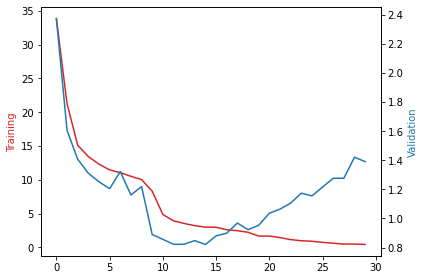

In [80]:
plot_train_val(train_history, valid_history)